In [152]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

from pelenet.utils import Utils
from pelenet.experiments.readoutrandom import ReadoutRandomExperiment
from pelenet.experiments.readout import ReadoutExperiment

In [92]:
# Initilizes utils
utils = Utils.instance()

In [9]:
# load data
sExRand = np.load('data/comparison/spikes_ex-random.npy')
sOutRand = np.load('data/comparison/spikes_out-random.npy')
sExAniso = np.load('data/comparison/spikes_ex-anisotropic.npy')
sOutAniso = np.load('data/comparison/spikes_out-anisotropic.npy')

In [146]:
# Matplotlib parameters
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['font.family'] = 'CMU Sans Serif'
plt.rcParams['font.size'] = 14

In [14]:
def readParameters():
    exp = ReadoutExperiment()
    return exp.p

p = readParameters()

# Differences between trials

Shows mean difference between trials. The single differences are normed with the number of neurons devided by the refractory period (with 3600 neurons and refractory period of 2, we expect maximum 1800 neurons to be active).

In [71]:
def calcTrialDiffs(data):
    diffs = []
    for i in range(p.trials):
        for j in range(p.trials):
            if i > j:
                # Get difference between data, devide by number of neurons
                diff = np.abs(data[i] - data[j])
                # Mean over neurons
                norm = data.shape[1]/p.refractoryDelay
                #norm = (np.sum(data[i] + data[j], axis=0))/2
                diff_mean = np.sum(diff, axis=0)/norm
                # Append to list
                diffs.append(diff_mean)
    
    # Make numpy array and return
    return np.array(diffs)

In [377]:
def plotDiffMean(diffsRand, diffsAniso):
    """
    Random network
    """
    # Calculate mean and standard deviation
    mr = np.mean(np.array(diffsRand), axis=0)
    sr = np.std(np.array(diffsRand), axis=0)
    # Plot mean
    plt.plot(mr, color=p.pltColor4, linewidth=2.0, label='Random')
    # Plot standard deviation around mean
    plt.fill_between(np.arange(210), mr-sr, mr+sr, color=p.pltColor4, alpha=0.5)
    
    """
    Anisotropic network
    """
    # Calculate mean and standard deviation
    ma = np.mean(np.array(diffsAniso), axis=0)
    sa = np.std(np.array(diffsAniso), axis=0)
    # Plot mean
    plt.plot(ma, color=p.pltColor3, linewidth=2.0, label='Anisotropic')
    # Plot standard deviation around mean
    plt.fill_between(np.arange(210), ma-sa, ma+sa, color=p.pltColor3, alpha=0.5)

    plt.legend()
    plt.xlim(0,200)
    plt.ylim(0,1)
    plt.xlabel('time steps')
    plt.ylabel('mean deviation between trials')
    # Save and show plot
    #plt.savefig(exp.net.plot.plotDir + 'trial-diff.' + p.pltFileType)
    pl = plt.show()

In [26]:
p = readParameters()

In [80]:
diffsRand = calcTrialDiffs(sExRand)
diffsAniso = calcTrialDiffs(sExAniso)

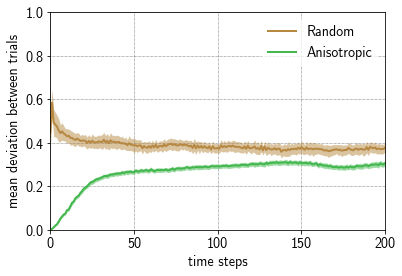

In [378]:
plotDiffMean(diffsRand, diffsAniso)

# PCA

In [233]:
# Bin spiking data
binSize = 10

def getBinnedSpikes(data):
    return np.array([np.mean(data[:, :, i:i+binSize], axis=2) for i in range(0,data.shape[2],binSize)])

def pcaAllTrials(bins):
    dtrans = []
    for i in tqdm(range(p.trials)):
        (d, evals, evecs) = utils.pca(bins[:,i,:].astype(float), dims_rescaled_data=2)
        dtrans.append(d)
        
    return np.array(dtrans)

def plotPca1d(pc, color):
    for i in range(p.trials):
        plt.plot(np.arange(0,p.stepsPerTrial,binSize), pc[i,:,0], linewidth=0.5, color=color)
    plt.xlabel('time steps')
    #plt.savefig(exp.net.plot.plotDir + 'pca1d.' + exp.p.pltFileType)
    p = plt.show()

def plotPca2d(pc, color):
    plt.figure(figsize=(10,4))
    ax = plt.axes(projection='3d')
    for i in range(p.trials):
        ax.plot3D(np.arange(0,p.stepsPerTrial,binSize), pc[i,:,0], pc[i,:,1], linewidth=0.5, color=color)
    ax.view_init(20,285)
    #ax.set_yticks([])
    #ax.set_zticks([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_xlabel('time steps', labelpad=40)
    ax.set_ylabel('PC1', labelpad=-5)
    ax.set_zlabel('PC2', labelpad=-5)
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.5, 0.8, 1]))  # scale_x, scale_y, scale_z, 1
    #plt.savefig(exp.net.plot.plotDir + 'pca3d.' + exp.p.pltFileType)
    pl = plt.show()

In [95]:
# Calculate bins
bExRand = getBinnedSpikes(sExRand)
bExAniso = getBinnedSpikes(sExAniso)

In [97]:
# Get first two pca components
p2ExRand = pcaAllTrials(bExRand)
p2ExAniso = pcaAllTrials(bExAniso)

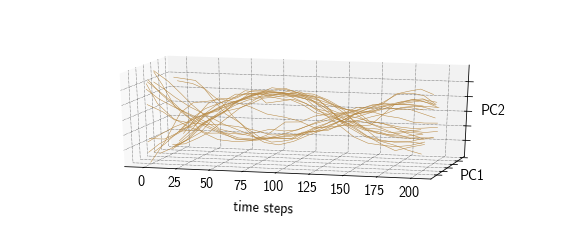

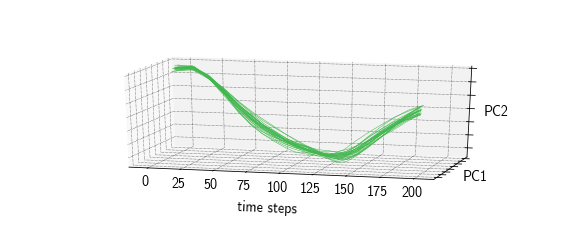

In [234]:
plotPca2d(p2ExRand, p.pltColor4)
plotPca2d(p2ExAniso, p.pltColor3)

# Multiple trajectories output learning

* 0 Random - Representation - Reservoir
* 1 Random - Representation - Pool 
* 2 Random - Generalisation - Reservoir
* 3 Random - Generalisation - Pool
* 4 Anisotropic - Representation - Reservoir
* 5 Anisotropic - Representation - Pool 
* 6 Anisotropic - Generalisation - Reservoir
* 7 Anisotropic - Generalisation - Pool

In [241]:
"""
Read targets
"""
filePath = 'data/robot2/hide_rec_dmp.txt'
targets = np.loadtxt(filePath)

files = [
    'hide_rec_dmp.txt',
    'move_up_rec_dmp.txt',
    'put_on_top_rec_dmp.txt',
    'unhide_rec_dmp.txt',
    'move_down_rec.txt',
    'pick_and_place_rec_dmp.txt',
    'take_down_rec_dmp.txt'
]

targets = np.array([ np.loadtxt('data/robot2/'+file)[-200:,0:3] for file in files ])
targets = np.moveaxis(targets, 1, 2)

In [243]:
estimates = {}

"""
Random network
"""

# Representation Reservoir
estimates['randRepRes'] = utils.estimateMultipleTrajectories3D(sExRand, targets, trainTrials=np.repeat(True, p.trials))
# Representation Pool
estimates['randRepPoo'] = utils.estimateMultipleTrajectories3D(sOutRand, targets, trainTrials=np.repeat(True, p.trials))
# Generalisation Reservoir
estimates['randGenRes'] = utils.estimateMultipleTrajectories3D(sExRand, targets)
# Generalisation Pool
estimates['randGenPoo'] = utils.estimateMultipleTrajectories3D(sOutRand, targets)

"""
Anisotropic network
"""

# Representation Reservoir
estimates['anisoRepRes'] = utils.estimateMultipleTrajectories3D(sExAniso, targets, trainTrials=np.repeat(True, p.trials))
# Representation Pool
estimates['anisoRepPoo'] = utils.estimateMultipleTrajectories3D(sOutAniso, targets, trainTrials=np.repeat(True, p.trials))
# Generalisation Reservoir
estimates['anisoGenRes'] = utils.estimateMultipleTrajectories3D(sExAniso, targets)
# Generalisation Pool
estimates['anisoGenPoo'] = utils.estimateMultipleTrajectories3D(sOutAniso, targets)


100%|██████████| 7/7 [10:30<00:00, 90.02s/it]

100%|██████████| 7/7 [00:01<00:00,  4.26it/s]

100%|██████████| 7/7 [09:53<00:00, 84.81s/it]

100%|██████████| 7/7 [00:01<00:00,  4.50it/s]

100%|██████████| 7/7 [10:17<00:00, 88.24s/it]

100%|██████████| 7/7 [00:01<00:00,  4.60it/s]

100%|██████████| 7/7 [09:48<00:00, 84.13s/it]

100%|██████████| 7/7 [00:01<00:00,  4.83it/s]


In [338]:
np.max(targets[0,0])

0.399167925119

In [340]:
np.max(targets[1,0])

0.770445644855

In [372]:
def calcNRMSE(estimates):
    err = []
    # Iterate over all trajectories
    for i in range(targets.shape[0]):
        # Iterate over all 3 dimensions
        nrmses = []
        for j in range(3):
            # Calculate mean squared error
            mse = np.mean(np.square(estimates[i,j] - targets[i,j]))
            # Square root mse
            rmse = np.sqrt(mse)
            # Normalise rmse
            nrmse = rmse/np.abs(np.mean(targets[i,j]))#/np.abs(np.mean(estimates[i,j]))
            nrmses.append(nrmse)
            
        err.append(np.mean(nrmses))
    return err

def plotRMSE(randVals, anisoVals, randYerr, anisoYerr, title):
    barWidth = 1
    
    plt.figure(figsize=(6,2.5))
    
    plt.bar([1,3.5], randVals, yerr=randYerr, width=barWidth, label='Random', color='#b78841', error_kw=dict(lw=1, capthick=1, capsize=4))
    plt.bar([2,4.5], anisoVals, yerr=anisoYerr, width=barWidth, label='Anisotropic', color='#41b74d', error_kw=dict(lw=1, capthick=1, capsize=4))
    
    plt.grid(axis='x')
    #plt.xticks(inds, labels)
    plt.xticks([1.5, 4], ['Reservoir', 'Pool'])
    plt.yscale('log')
    plt.title(title)
    plt.ylabel('Normalized root mean squared error')
    plt.legend()
    plt.show()
    
def printTtest(mse, key1, key2):
    pval = stats.ttest_ind(mse[key1], mse[key2])[1]
    print("{} vs. {}: p = {:.10f}".format(key1, key2, pval))
    

In [358]:
mse = {}
mseMean = {}
mseStd = {}

for key, est in estimates.items():
    mse[key] = calcNRMSE(est)
    mseMean[key] = np.mean(mse[key])
    mseStd[key] = np.std(mse[key])

randRepRes vs. randRepPoo: p = 0.0009544048
anisoRepRes vs. anisoRepPoo: p = 0.0020578522


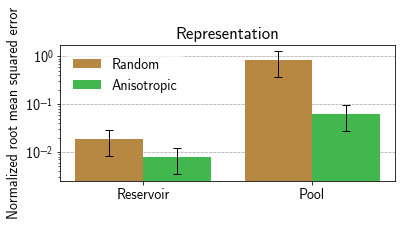

In [373]:
printTtest(mse, 'randRepRes', 'randRepPoo')
printTtest(mse, 'anisoRepRes', 'anisoRepPoo')

vals1 = np.array([mseMean['randRepRes'], mseMean['randRepPoo']])
vals2 = np.array([mseMean['anisoRepRes'], mseMean['anisoRepPoo']])
yerr1 = np.array([mseStd['randRepRes'], mseStd['randRepPoo']])
yerr2 = np.array([mseStd['anisoRepRes'], mseStd['anisoRepPoo']])

plotRMSE(vals1, vals2, yerr1, yerr2, 'Representation')

randGenRes vs. randGenPoo: p = 0.0023406166
anisoGenRes vs. anisoGenPoo: p = 0.0013928877


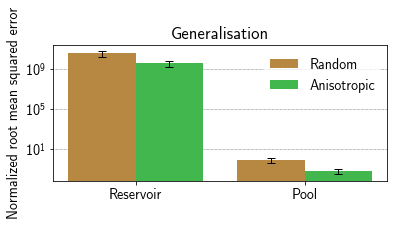

In [374]:
printTtest(mse, 'randGenRes', 'randGenPoo')
printTtest(mse, 'anisoGenRes', 'anisoGenPoo')

vals1 = np.array([mseMean['randGenRes'], mseMean['randGenPoo']])
vals2 = np.array([mseMean['anisoGenRes'], mseMean['anisoGenPoo']])
yerr1 = np.array([mseStd['randGenRes'], mseStd['randGenPoo']])
yerr2 = np.array([mseStd['anisoGenRes'], mseStd['anisoGenPoo']])

plotRMSE(vals1, vals2, yerr1, yerr2, 'Generalisation')

# Details trajectory readout learning

# Generalisation pool

In [ ]:
targets

estimates['anisoGenPoo']

In [ ]:
"""
Generalisation Pool
"""
# Prepare data
(x, xe, y) = utils.prepareDataset(exp.net.outSpikeData, exp.target)

# Estimate and plot x-dim
x1 = utils.estimateMovement(x, xe, y[0])
exp.net.plot.movement1D(x1, exp.target[0], dim='x', ylim=(0.175,0.375), figsize=(6,2))

# Estimate and plot y-dim
x2 = utils.estimateMovement(x, xe, y[1])
exp.net.plot.movement1D(x2, exp.target[1], dim='y', ylim=(0.595,0.655), figsize=(6,2))

# Estimate and plot z-dim
x3 = utils.estimateMovement(x, xe, y[2])
exp.net.plot.movement1D(x3, exp.target[2], dim='z', ylim=(-0.06,0.06), figsize=(6,2))

# Plot 3D
exp.net.plot.movement3D(
    [x1, x2, x3], exp.target, figsize=(10,8),
    xlim=(0.175,0.375), ylim=(0.595,0.655), zlim=(-0.06,0.06)
)